## This is a code for applying tensor component analysis (Williams et al., 2018, Neuron) to larval zebra fish whole brain calcium imaging data (Chen et al., 2018, Neuron)

Williams, A. H., Kim, T. H., Wang, F., Vyas, S., Ryu, S. I., Shenoy, K. V., ... & Ganguli, S. (2018). Unsupervised discovery of demixed, low-dimensional neural dynamics across multiple timescales through tensor component analysis. Neuron, 98(6), 1099-1115.

Chen, X., Mu, Y., Hu, Y., Kuan, A. T., Nikitchenko, M., Randlett, O., ... & Ahrens, M. B. (2018). Brain-wide organization of neuronal activity and convergent sensorimotor transformations in larval zebrafish. Neuron, 100(4), 876-890.

In [1]:
cd C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6

C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6


In [2]:
%matplotlib notebook

In [2]:
#For the TCA, I used tensorflow library which made by Williams(https://github.com/ahwillia/tensortools)
#For the larval zebrafish imaging data, I used Dr. Misha Ahrens' data(https://janelia.figshare.com/articles/Whole-brain_light-sheet_imaging_data/7272617)

## Libraries
import numpy as np
import h5py
import os
import tensortools as tt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from scipy.io import loadmat
import seaborn as ssn
from sklearn.metrics import r2_score

In [3]:
##Basic preparation
#Open the File and do basic steps
f = h5py.File('TimeSeries.h5', 'r')
CellResp = f['/CellResp']
CellResp = np.transpose(CellResp)
absIX = f['/absIX']
absIX = absIX[0].astype(int)

data = loadmat('data_full.mat')
Cell = data['data']['CellXYZ_norm'] #Get the normalized cell positions (X, Y, Z)
Cell = Cell[0][0]
Cell = np.vstack((Cell[0], Cell[absIX[:-1]]))
stim = data['data']['stim_full'] #Get the stimuli info
stim = stim[0][0][0]
fpsec = data['data']['fpsec'] #Frame per second
fpsec = fpsec[0][0][0][0]
Beh_full = data['data']['Behavior_full'][0, 0]
Beh_seed = data['data']['Behavior_full_motorseed'][0, 0]
Beh_seed = Beh_seed.T
stim_1 = CellResp[:, np.where(stim==1)[0]] #Organize the calcium imaging data belongs to each stimuli 
stim_2 = CellResp[:, np.where(stim==2)[0]]
stim_3 = CellResp[:, np.where(stim==3)[0]]

In [4]:
num_stim1, num_stim2, num_stim3 = 0, 0, 0
for i in range (len(stim)):
    if stim[i] == 1:
        num_stim1 += 1
    if stim[i] == 2:
        num_stim2 += 1
    if stim[i] == 3:
        num_stim3 += 1
        
#real_stim1 = np.array(stim_1).reshape(np.shape(stim_1)[0], 40, num_stim1//40)

In [5]:
#I should know which stimulus type(stim_type =[1, 2, 3]) is continued first
temp_num = 0
count_val = {}
init_num = 0
for i in range (0, len(stim)):
    if i == len(stim)-1:
        temp_num += 1
        count_val[init_num] = (stim[i], temp_num)
    elif stim[i]==stim[i+1]:
        temp_num += 1
    elif stim[i]!=stim[i+1]:
        temp_num += 1
        count_val[init_num] = (stim[i], temp_num)
        temp_num = 0
        init_num += 1
    else:
        print("err")
#So, count_val[i, j] means i type of stimulus is continuing for j frames 

max_num = max(count_val.keys())

In [6]:
#I should make tensor matrix but since the type 1, 2 stim continuing for 40 frames and type 3 stim continuing for 30 frames
#So I will cut the 40 frames to 30frames by trimming the later 10 frames 
real_stim = CellResp[:, :count_val[0][1]]
for t in range (0, max_num+1):
    if t==0:
        temp = count_val[0][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == 10:
        real_stim = np.dstack((real_stim, CellResp[:, temp:temp+count_val[t][1]-10]))
        temp += count_val[t][1]
        print(temp)
    elif count_val[t][1]-count_val[t-1][1] == -10:
        real_stim= np.dstack((real_stim, CellResp[:, temp:temp+count_val[t][1]]))
        temp += count_val[t][1]
        print(temp)
    else:
        print("err")

30
70
100
140
170
210
240
280
310
350
380
420
450
490
520
560
590
630
660
700
730
770
800
840
870
910
940
980
1010
1050
1080
1120
1150
1190
1220
1260
1290
1330
1360
1400
1430
1470
1500
1540
1570
1610
1640
1680
1710
1750
1780
1820
1850
1890
1920
1960
1990
2030
2060
2100
2130
2170
2200
2240
2270
2310
2340
2380
2410
2450
2480
2520
2550
2590
2620
2660
2690
2730
2760
2800
2830
2870
2900
2940
2970
3010
3040
3080
3110
3150
3180
3220
3250
3290
3320
3360
3390
3430
3460
3500
3530
3570
3600
3640
3670
3710
3740
3780


In [8]:
#When you want to load the saved CP_ALS data
cd C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6\cp_als
    
cp = {}
for rank in range(1, 30):
    print(rank)
    for repli in range(0, 10):
        file_0 = "%s_%s_0.csv" %(rank, repli)
        file_1 = "%s_%s_1.csv" %(rank, repli)
        file_2 = "%s_%s_2.csv" %(rank, repli)

        df_1= pd.read_csv(file_0)
        df_2= pd.read_csv(file_1)
        df_3= pd.read_csv(file_2)

        df = tt.KTensor((df_1.values, df_2.values, df_3.values))
        cp[rank, repli] = df
print("loading done")
del df_1, df_2, df_3, df

C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6\cp_als


In [9]:
#CP_ALS similiarity calculation

normX = np.linalg.norm(real_stim)
X = real_stim
cp = {}
for rank in range(1, 30):
    print(rank)
    for repli in range(0, 10):
        file_0 = "%s_%s_0.csv" %(rank, repli)
        file_1 = "%s_%s_1.csv" %(rank, repli)
        file_2 = "%s_%s_2.csv" %(rank, repli)

        df_1= pd.read_csv(file_0)
        df_2= pd.read_csv(file_1)
        df_3= pd.read_csv(file_2)

        df = tt.KTensor((df_1.values, df_2.values, df_3.values))
        cp[rank, repli] = df
print("loading done")
del df_1, df_2, df_3, df

sim_cp = {}
obj_cp = {}
for rank in range(1, 29):
    print(rank)
    for repli in range(0, 10):
        U = cp[rank, repli]
        V = cp[rank+1, repli]
        sim_cp[rank, repli] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        obj_cp[rank, repli] = np.linalg.norm(U.full() - X) / normX
        
for repli in range(0, 10):
    obj_cp[29, repli] = np.linalg.norm(U.full() - X) / normX
del U, V

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
loading done
1


NameError: name 'X' is not defined

In [31]:
#Code from Github of tensor tools package
#'''https://github.com/ahwillia/tensortools'''

from tensortools.operations import unfold, khatri_rao
from tensortools.tensors import KTensor
from tensortools.optimize import FitResult, optim_utils
import scipy

X = real_stim

normX = np.linalg.norm(X)
skip_modes=[]
cp_obj = {}
for rank in range(1, 30):
    print(rank)
    for repli in range(0, 10):
        U = cp[rank, repli]
        for n in range(X.ndim):

            # Skip modes that are specified as fixed.
            if n in skip_modes:
                continue

            # i) Normalize factors to prevent singularities.
            U.rebalance()

            # ii) Compute the N-1 gram matrices.
            components = [U[j] for j in range(X.ndim) if j != n]
            grams = np.prod([u.T @ u for u in components], axis=0)

            # iii)  Compute Khatri-Rao product.
            kr = khatri_rao(components)

            # iv) Form normal equations and solve via Cholesky
            c = scipy.linalg.cho_factor(grams, overwrite_a=False)
            p = unfold(X, n).dot(kr)
            U[n] = scipy.linalg.cho_solve(c, p.T, overwrite_b=False).T

        obj = np.linalg.norm(U.full() - X) / normX
        cp_obj[rank, repli] = obj

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [33]:
cd C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6

C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6


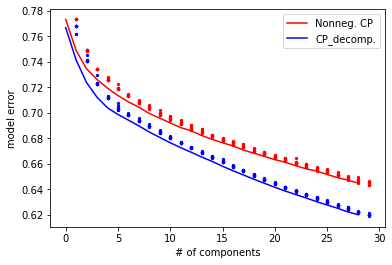

In [69]:
# Error score plotting

mean_obj = []
for i in range(1, 30):
    temp = []
    for x in range(0, 10):
        plt.scatter(np.repeat(i, 1), cp_obj[i, x], c='blue', s=5)
        plt.scatter(np.repeat(i, 1), bcd_obj.iloc[x, i], c='red', s=5)
        #plt.scatter(np.repeat(i, 1), obj_cp[i, x], c='red')
        temp.append(cp_obj[i, x])
    mean_obj.append(np.mean(temp))
    
#plt.scatter(np.repeat(np.arange(30), 9), bcd_obj.T.iloc[:, 1:], c='red', s=5)
plt.plot(np.arange(29), np.mean(bcd_obj.iloc[:, 1:]), c='red', label='Nonneg. CP')

plt.plot(np.arange(29), mean_obj, c='blue', label='CP_decomp.')


plt.legend()
plt.xlabel('# of components')
plt.ylabel('model error')
plt.savefig('both_error.png', dpi=600)

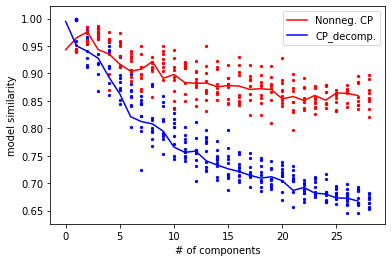

In [80]:
#Similarity score
mean_sim = []
for i in range(1, 29):
    temp = []
    for x in range(0, 10):
        plt.scatter(np.repeat(i, 1), sim_cp[i, x], c='blue', s=5)
        #plt.scatter(np.repeat(i, 1), obj_cp[i, x], c='red')
        temp.append(sim_cp[i, x])
    mean_sim.append(np.mean(temp))
plt.scatter(np.repeat(bcd_sim.iloc[:-1, 0], 9), bcd_sim.iloc[:-1, 1:], c='red', s=5)
plt.plot(np.arange(28), np.mean(bcd_sim.iloc[:-1, 1:], axis=1), c='red', label='Nonneg. CP')
plt.plot(np.arange(28), mean_sim, c='blue', label='CP_decomp.')

plt.legend()
plt.xlabel('# of components')
plt.ylabel('model similarity')

plt.savefig('both similarity.png', dpi=600)

In [44]:
#To save TCA-optimiczed data
rank = 29
repli = 0
file_0 = "%s_%s_0.csv" %(rank, repli)
file_1 = "%s_%s_1.csv" %(rank, repli)
file_2 = "%s_%s_2.csv" %(rank, repli)

df_1= pd.read_csv(file_0)
df_2= pd.read_csv(file_1)
df_3= pd.read_csv(file_2)

df = tt.KTensor((df_1.values, df_2.values, df_3.values))
test[rank, repli] = df

In [11]:
#Optimization(TCA)
ensembles = {}

for r in range(25, 30):
    ensembles['cp_als'] = tt.Ensemble(fit_method='cp_als', fit_options=dict(tol=1e-4))
    ensembles['cp_als'].fit(real_stim, ranks=r, replicates=10)
  
    rank = r
    for repli in range(0, 10):
        data_name_0 = "%s_%s_0.csv" %(rank, repli) 
        data_name_1 = "%s_%s_1.csv" %(rank, repli)
        data_name_2 = "%s_%s_2.csv" %(rank, repli)

        df_1 = pd.DataFrame(ensembles['cp_als'].factors(rank)[repli][0])
        df_2 = pd.DataFrame(ensembles['cp_als'].factors(rank)[repli][1])
        df_3 = pd.DataFrame(ensembles['cp_als'].factors(rank)[repli][2])

        df_1.to_csv(data_name_0)
        df_2.to_csv(data_name_1)
        df_3.to_csv(data_name_2)

Rank-25 models:  min obj, 0.63;  max obj, 0.63;  time to fit, 2199.7s


Rank-26 models:  min obj, 0.63;  max obj, 0.63;  time to fit, 2240.5s


Rank-27 models:  min obj, 0.63;  max obj, 0.63;  time to fit, 2353.2s


Rank-28 models:  min obj, 0.62;  max obj, 0.62;  time to fit, 2266.1s


Rank-29 models:  min obj, 0.62;  max obj, 0.62;  time to fit, 2263.2s


In [ ]:
#Plot the model Error score
fig1, ax1 = plt.subplots(figsize=(10, 10))
#ax1.plot(hals_obj[1:-1, 0], hals_obj[1:-1, 1], label='NCP_HALS', c='blue')
ax1.plot(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1], label='NCP_BCD', c='red')
#ax1.plot(cp_obj[1:-1, 0], cp_obj[1:-1, 1], label='CP_ALS', c='black')
#ax1.scatter(hals_obj[1:-1, 0], hals_obj[1:-1, 1], c='blue', s=10)
ax1.scatter(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1],  c='red', s=10)
#ax1.scatter(cp_obj[1:-1, 0], cp_obj[1:-1, 1], c='black', s=10)
ax1.set_xlabel('model rank')
ax1.set_ylabel('Objective')
ax1.set_ylim([0, 1.1])
plt.title('Model Error score')
ax1.legend()

plt.savefig('Model Error score', dpi=600)

"""
#Plot the model Error score
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(hals_obj[1:-1, 0], hals_obj[1:-1, 1], label='NCP_HALS', c='blue')
ax1.plot(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1], label='NCP_BCD', c='red')
ax1.plot(cp_obj[1:-1, 0], cp_obj[1:-1, 1], label='CP_ALS', c='black')
ax1.scatter(hals_obj[1:-1, 0], hals_obj[1:-1, 1], c='blue', s=10)
ax1.scatter(bcd_obj[1:-1, 0], bcd_obj[1:-1, 1],  c='red', s=10)
ax1.scatter(cp_obj[1:-1, 0], cp_obj[1:-1, 1], c='black', s=10)
ax1.set_xlabel('model rank')
ax1.set_ylabel('Objective')
ax1.set_ylim([0, 1.1])
plt.title('Model Error score')
ax1.legend()

plt.savefig('Model Error score', dpi=600)
"""

In [95]:
#Calculate model similarity
cp_sim1, bcd_sim1, hals_sim1 = np.zeros((30, 10)), np.zeros((30, 10)), np.zeros((30, 10))

repli=range(1, 10)
ranks=range(1, 30)
for i in range(1, len(ranks)):
    r0, r1 = ranks[i-1], ranks[i]
    for j in repli:
        U = ensembles['ncp_bcd'].results[r0][j].factors
        V = ensembles['ncp_bcd'].results[r1][j].factors
        #if m == 'cp_als':
            #cp_sim1[i, 0] = i
            #cp_sim1[i, 1] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        #if m == 'ncp_bcd':
        bcd_sim1[i, 0] = i
        bcd_sim1[i, j] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        #if m == 'ncp_hals':
            #hals_sim1[i, 0] = i
            #hals_sim1[i, 1] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
"""
#Plot the model similarity
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(hals_sim1[1:-1, 0], hals_sim1[1:-1, 1], label='NCP_HALS', c='blue')
ax.plot(bcd_sim1[1:-1, 0], bcd_sim1[1:-1, 1], label='NCP_BCD', c='red')
ax.plot(cp_sim1[1:-1, 0], cp_sim1[1:-1, 1], label='CP_ALS', c='black')
ax.scatter(hals_sim1[1:-1, 0], hals_sim1[1:-1, 1], c='blue', s=10)
ax.scatter(bcd_sim1[1:-1, 0], bcd_sim1[1:-1, 1],  c='red', s=10)
ax.scatter(cp_sim1[1:-1, 0], cp_sim1[1:-1, 1], c='black', s=10)
ax.set_xlabel('model rank')
ax.set_ylabel('model similarity')
ax.set_ylim([0, 1.1])
plt.title('Model Similarity')
ax.legend()
"""

"""
mean_obj= []
for i in range(1, 30):
    mean_obj.append(bcd_obj[i])
mean_obj1 = np.mean(mean_obj)

mean_sim = []
for i in range(1, 29):
    mean_sim.append(np.mean(ensembles['ncp_bcd'].similarities(i)))
    print(i, mean_sim[i])
"""

"""
#Calculate model similarity
cp_sim1, bcd_sim1, hals_sim1 = np.zeros((30, 10)), np.zeros((30, 10)), np.zeros((30, 10))

repli=range(1, 10)
ranks=range(1, 30)
for i in range(1, len(ranks)):
    r0, r1 = ranks[i-1], ranks[i]
    for j in repli:
        U = ensembles['ncp_bcd'].results[r0][j].factors
        V = ensembles['ncp_bcd'].results[r1][j].factors
        #if m == 'cp_als':
            #cp_sim1[i, 0] = i
            #cp_sim1[i, 1] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        #if m == 'ncp_bcd':
        bcd_sim1[i, 0] = i
        bcd_sim1[i, j] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
        #if m == 'ncp_hals':
            #hals_sim1[i, 0] = i
            #hals_sim1[i, 1] = tt.kruskal_align(U, V, permute_U=True, permute_V=True)
"""

In [225]:
%matplotlib inline

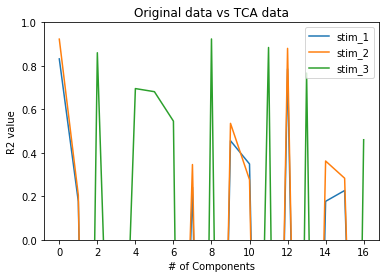

In [393]:
#Calculate R2 value between original data and TCA-data under normalized condition
mean_stim1 = np.mean(np.mean(real_stim[:, :, stim_1], axis=2), axis=0)
mean_stim2 = np.mean(np.mean(real_stim[:, :, stim_2], axis=2), axis=0)
mean_stim3 = np.mean(np.mean(real_stim[:, :, stim_3], axis=2), axis=0)

scaler1 = MinMaxScaler().fit(mean_stim1.reshape(-1, 2))
norm_stim1 = scaler1.transform(mean_stim1.reshape(-1, 2)).reshape(-1, 1)

scaler2 = MinMaxScaler().fit(mean_stim2.reshape(-1, 2))
norm_stim2 = scaler2.transform(mean_stim2.reshape(-1, 2)).reshape(-1, 1)

scaler3 = MinMaxScaler().fit(mean_stim3.reshape(-1, 2))
norm_stim3 = scaler3.transform(mean_stim3.reshape(-1, 2)).reshape(-1, 1)

norm_list = [norm_stim1, norm_stim2, norm_stim3]

r2_mat1 = np.zeros((17, 3))
for j in range(0, 3):
    for i in range(0, 17):
        #stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, i]
        scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
        norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)
        
        r2_val = r2_score(norm_candi1, norm_list[j])
        r2_mat1[i, j] = r2_val
        
plt.plot(r2_mat[:,  0], label='stim_1')
plt.plot(r2_mat[:,  1], label='stim_2')
plt.plot(r2_mat[:,  2], label='stim_3')
plt.legend()
plt.ylim([0,  1])
plt.xlabel('# of Components')
plt.ylabel('R2 value')
plt.title('Original data vs TCA data')
plt.savefig('R2value_comparison.png', dpi=600)
plt.show()

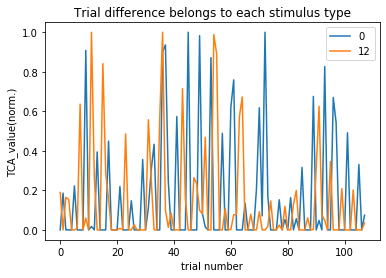

In [410]:
#Distinguish which component belongs to which stim_type 1, 2
scaler_0 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 0].reshape(-1, 2))
norm_0 = scaler_0.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 0].reshape(-1, 2)).reshape(-1, 1)

scaler_12 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 12].reshape(-1, 2))
norm_12 = scaler_12.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 12].reshape(-1, 2)).reshape(-1, 1)

plt.plot(norm_0, label='0')
plt.plot(norm_12, label='12')
plt.legend()
plt.xlabel('trial number')
plt.ylabel('TCA_value(norm.)')
plt.title('Trial difference belongs to each stimulus type')
#plt.xlim([0, 20])
plt.savefig('Trial difference belongs to each stimulus type.png', dpi=600)


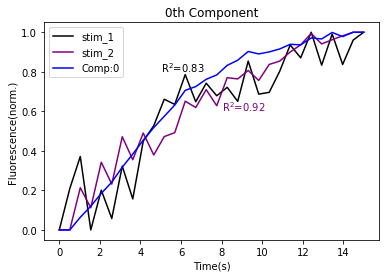

In [467]:
#R2 representing plot(Stim1, 2 vs Comp:0)
stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 0]
scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)

r2_val = r2_score(norm_candi1, norm_list[j])
plt.plot(np.linspace(0, 15, 30), norm_stim1, c='black', label='stim_1')
plt.plot(np.linspace(0, 15, 30), norm_stim2, c='purple', label='stim_2')

plt.plot(np.linspace(0, 15, 30), norm_candi1, c='blue', label='Comp:0')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Fluorescence(norm.)')
plt.text(5, .8, r'$\mathregular{R^2}}$=0.83', color='black')
plt.text(8, .6, r'$\mathregular{R^2}}$=0.92', color='purple')
plt.title('0th Component')
plt.savefig('[stim1,2]comp0 R2.png', dpi=600)

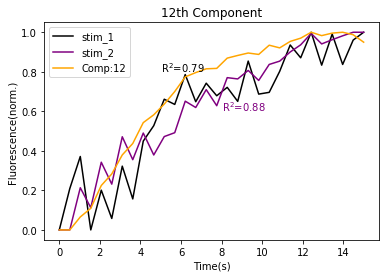

In [456]:
#R2 representing plot(Stim1, 2 vs Comp:12)
stim_1_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 12]
scaler0 = MinMaxScaler().fit(stim_1_candi.reshape(-1, 2))
norm_candi1 = scaler0.transform(stim_1_candi.reshape(-1, 2)).reshape(-1, 1)

r2_val = r2_score(norm_candi1, norm_list[j])
plt.plot(np.linspace(0, 15, 30), norm_stim1, c='black', label='stim_1')
plt.plot(np.linspace(0, 15, 30), norm_stim2, c='purple', label='stim_2')

plt.plot(np.linspace(0, 15, 30), norm_candi1, c='Orange', label='Comp:12')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Fluorescence(norm.)')
plt.text(5, .8, r'$\mathregular{R^2}}$=0.79', color='black')
plt.text(8, .6, r'$\mathregular{R^2}}$=0.88', color='purple')
plt.title('12th Component')

plt.savefig('[stim1,2]comp12 R2.png', dpi=600)

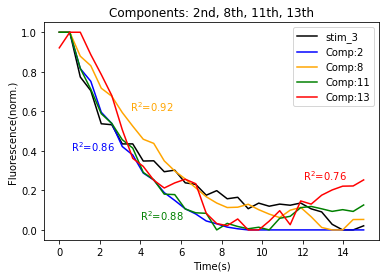

In [468]:
#R2 representing plot(Stim3 vs Comp:2, 8, 11, 13)
stim_2_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 2]
scaler_2 = MinMaxScaler().fit(stim_2_candi.reshape(-1, 2))
norm_candi2 = scaler_2.transform(stim_2_candi.reshape(-1, 2)).reshape(-1, 1)

stim_8_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 8]
scaler_8 = MinMaxScaler().fit(stim_8_candi.reshape(-1, 2))
norm_candi8 = scaler_8.transform(stim_8_candi.reshape(-1, 2)).reshape(-1, 1)

stim_11_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 11]
scaler_11 = MinMaxScaler().fit(stim_11_candi.reshape(-1, 2))
norm_candi11 = scaler_11.transform(stim_11_candi.reshape(-1, 2)).reshape(-1, 1)

stim_13_candi = ensembles['ncp_bcd'].factors(17)[7][1][:, 13]
scaler_13 = MinMaxScaler().fit(stim_13_candi.reshape(-1, 2))
norm_candi13 = scaler_13.transform(stim_13_candi.reshape(-1, 2)).reshape(-1, 1)

r2_val = r2_score(norm_candi1, norm_list[j])
plt.plot(np.linspace(0, 15, 30), norm_stim3, c='black', label='stim_3')
plt.plot(np.linspace(0, 15, 30), norm_candi2, c='blue', label='Comp:2')
plt.plot(np.linspace(0, 15, 30), norm_candi8, c='orange', label='Comp:8')
plt.plot(np.linspace(0, 15, 30), norm_candi11, c='green', label='Comp:11')
plt.plot(np.linspace(0, 15, 30), norm_candi13, c='red', label='Comp:13')

plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Fluorescence(norm.)')
plt.text(0.6, .4, r'$\mathregular{R^2}}$=0.86', color='blue')
plt.text(3.5, .6, r'$\mathregular{R^2}}$=0.92', color='orange')
plt.text(4, .05, r'$\mathregular{R^2}}$=0.88', color='green')
plt.text(12, .25, r'$\mathregular{R^2}}$=0.76', color='red')

plt.title('Components: 2nd, 8th, 11th, 13th')
plt.savefig('[stim3]comp2,8,11,13 R2.png', dpi=600)

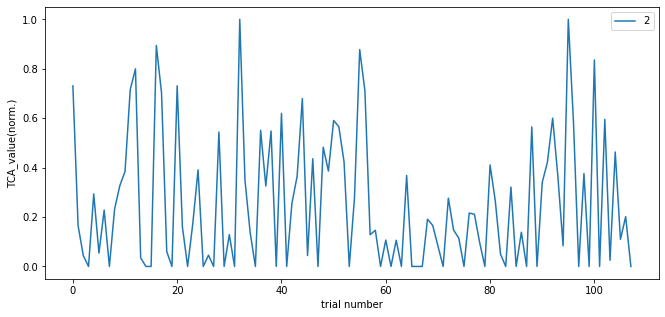

In [424]:
#Let's figure out what is different in stim 3

scaler_2 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2))
norm_2 = scaler_2.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 2].reshape(-1, 2)).reshape(-1, 1)

scaler_8 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 8].reshape(-1, 2))
norm_8 = scaler_8.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 8].reshape(-1, 2)).reshape(-1, 1)

scaler_11 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 11].reshape(-1, 2))
norm_11 = scaler_11.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 11].reshape(-1, 2)).reshape(-1, 1)

scaler_13 = MinMaxScaler().fit(ensembles['ncp_bcd'].factors(17)[7][2][:, 13].reshape(-1, 2))
norm_13 = scaler_13.transform(ensembles['ncp_bcd'].factors(17)[7][2][:, 13].reshape(-1, 2)).reshape(-1, 1)

_, ax = plt.subplots(figsize=(11, 5))
ax.plot(norm_2, label='2')
#ax.plot(norm_8, label='8')
#ax.plot(norm_11, label='11')
#ax.plot(norm_13, label='13')
ax.legend()
ax.set_xlabel('trial number')
ax.set_ylabel('TCA_value(norm.)')
#plt.title('Trial component values belong to stim_type 3')
plt.savefig('Only 2_Trial component values belong to stim_type 3.png', dpi=600)
plt.show()

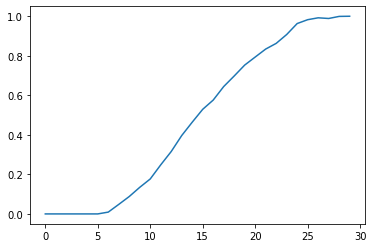

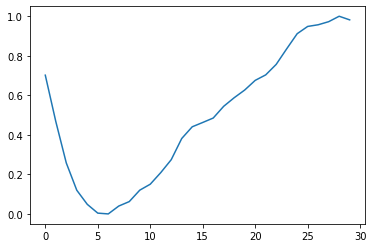

0.799228068056109

In [83]:
##Let's compare the TCA and original data(norm. averaged)
component=6
thre=0.2(threshold)

#TCA DATA normalization
TCA_data = np.zeros((30, 2))
TCA_data[:, 0] = np.arange(30)
TCA_data[:, 1] = ensembles['ncp_bcd'].factors(27)[0][1][:, comp]
scaler1 = MinMaxScaler().fit(TCA_data)
norm_TCA_data = scaler1.transform(TCA_data)
plt.figure()
_=plt.plot(norm_TCA_data[:, 1])

#Original Data normalization
sel_data = np.nonzero(ensembles['ncp_bcd'].factors(27)[0][0][:, comp]>thre)[0]
#print(sel_data)
#print(np.mean(trial_mean[sel_data, :], 0))
temp_data = np.zeros((30, 2))
temp_data[:, 0] = np.arange(30)
temp_data[:, 1] = np.mean(trial_mean[sel_data, :], 0)
scaler = MinMaxScaler().fit(temp_data)
norm_data = scaler.transform(temp_data)
plt.figure()
_=plt.plot(norm_data[:, 1])

plt.show()

#Calculate R2 value
r2_score(norm_TCA_data[:, 1], norm_data[:, 1])

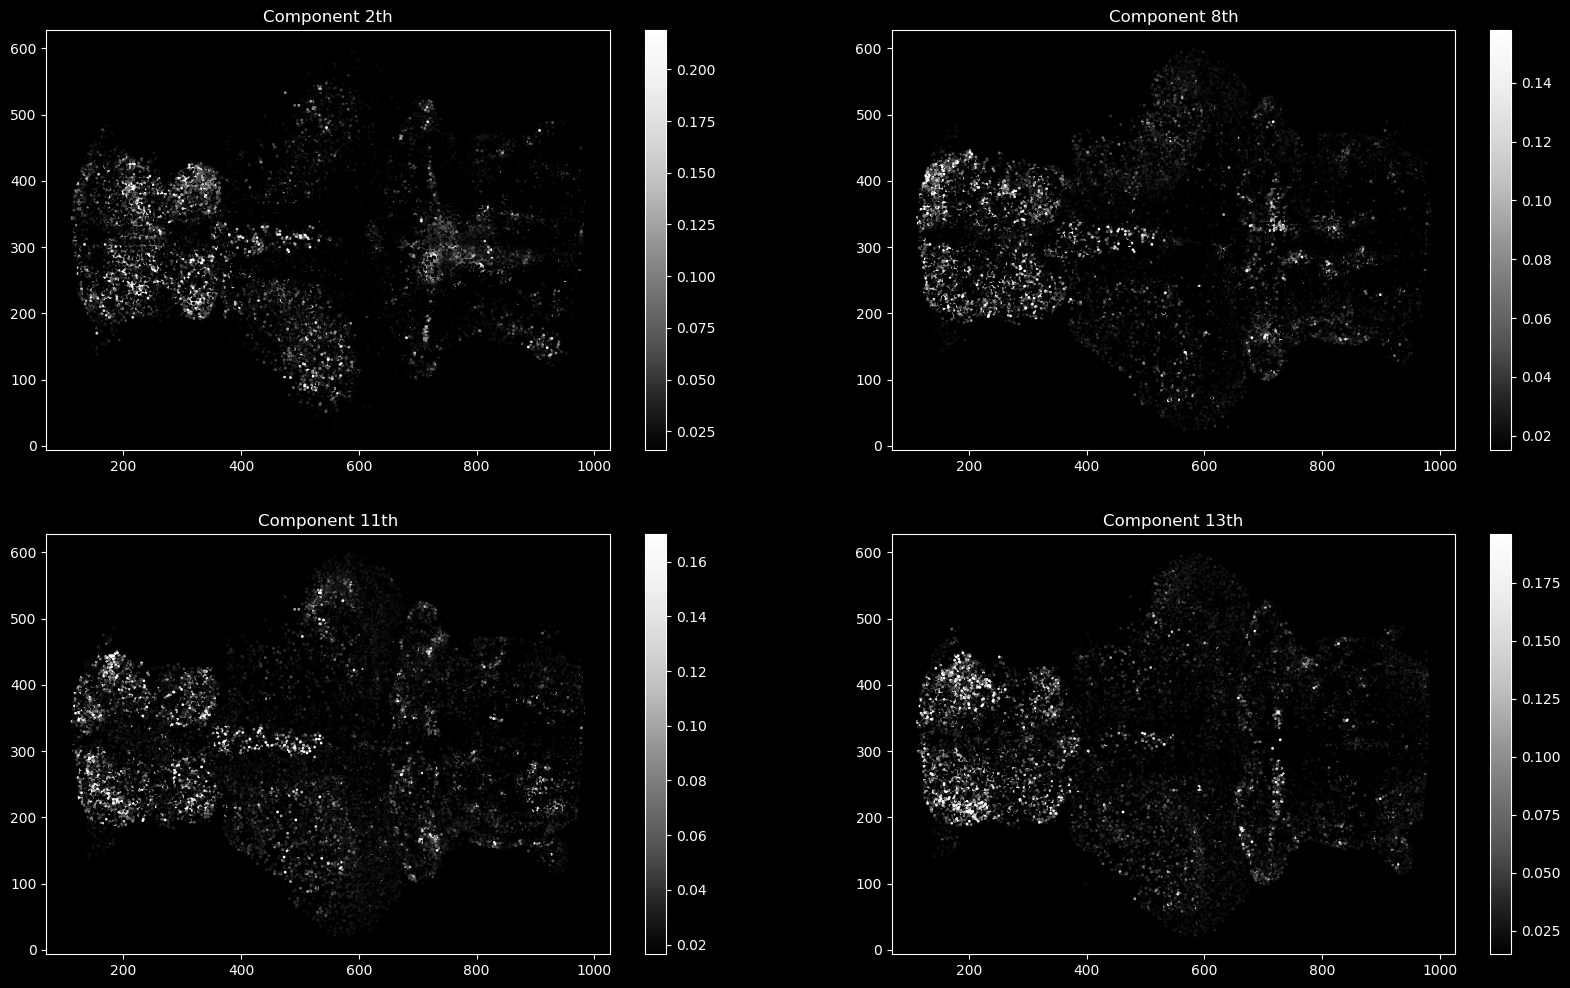

In [514]:
#Stim_3's neural factor #2, 8, 11, 13
plt.style.use('dark_background')

scaler= MinMaxScaler().fit(df_1.values[:, 3].reshape(-1, 2))
norm_2 = scaler.transform(df_1.values[:, 3].reshape(-1, 2)).reshape(-1, 1)

scaler= MinMaxScaler().fit(df_1.values[:, 9].reshape(-1, 2))
norm_8 = scaler.transform(df_1.values[:, 9].reshape(-1, 2)).reshape(-1, 1)

scaler= MinMaxScaler().fit(df_1.values[:, 12].reshape(-1, 2))
norm_11 = scaler.transform(df_1.values[:, 12].reshape(-1, 2)).reshape(-1, 1)

scaler= MinMaxScaler().fit(df_1.values[:, 14].reshape(-1, 2))
norm_13 = scaler.transform(df_1.values[:, 14].reshape(-1, 2)).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(20, 12), nrows=2, ncols=2)

med_2 = np.median(norm_2)
std_2 = np.std(norm_2)

med_8 = np.median(norm_8)
std_8 = np.std(norm_8)

med_11 = np.median(norm_11)
std_11 = np.std(norm_11)

med_13 = np.median(norm_13)
std_13 = np.std(norm_13)

ax0 = ax[0, 0].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_2[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_2, vmax=med_2+std_2*6)
ax0 = ax[0, 0].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_2[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_2, vmax=med_2+std_2*6)
ax[0, 0].set_title('Component 2th')
plt.colorbar(ax0, ax=ax[0, 0])

ax1 = ax[0, 1].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_8[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_8, vmax=med_8+std_8*6)
ax1 = ax[0, 1].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_8[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_8, vmax=med_8+std_8*6)
ax[0, 1].set_title('Component 8th')
plt.colorbar(ax1, ax=ax[0, 1])

ax2 = ax[1, 0].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_11[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_11, vmax=med_11+std_11*6)
ax2 = ax[1, 0].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_11[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_11, vmax=med_11+std_11*6)
ax[1, 0].set_title('Component 11th')
plt.colorbar(ax2, ax=ax[1, 0])

ax3 = ax[1, 1].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_13[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_13, vmax=med_13+std_13*6)
ax3 = ax[1, 1].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_13[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_13, vmax=med_13+std_13*6)
ax[1, 1].set_title('Component 13th')
plt.colorbar(ax3, ax=ax[1, 1])
#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
#ax.spines['right'].set_color('white')
#ax.spines['left'].set_color('white')
#ax.yaxis.label.set_color('white')
#ax.xaxis.label.set_color('white')
#ax.patch.set_facecolor('black')
#plt.savefig('Each_comp_visual.png', dpi=600)

plt.show()

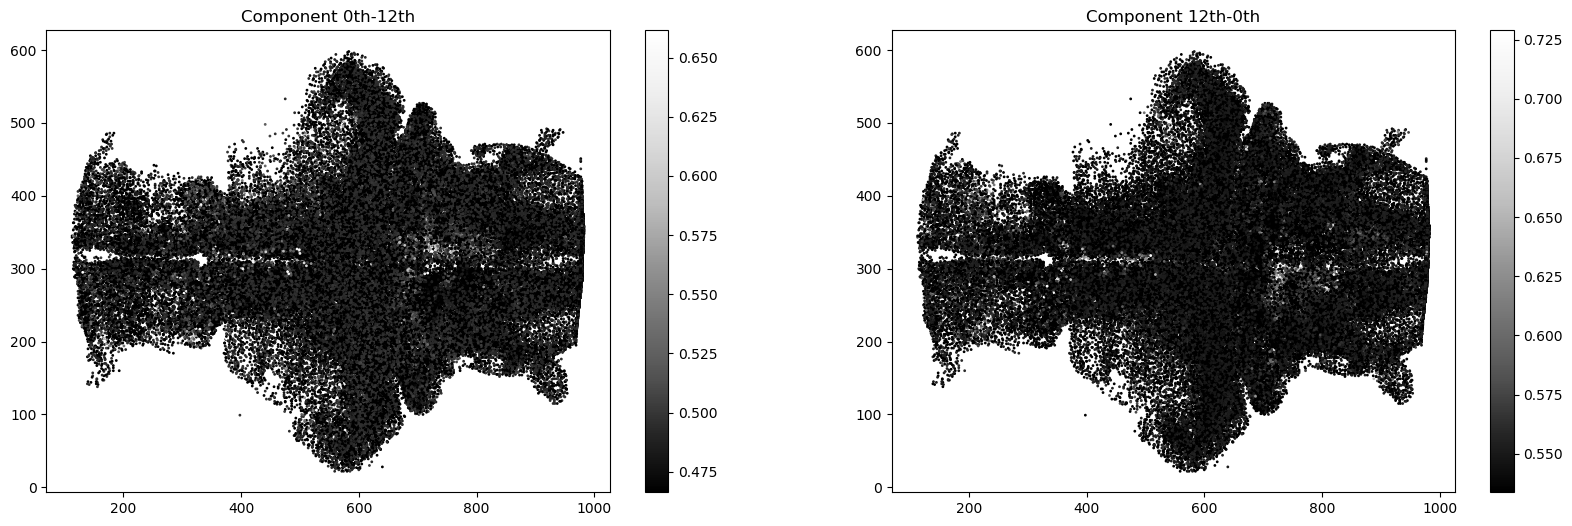

In [503]:
#Difference of the components' plot
df_12 = df_1.values[:, 1] - df_1.values[:, 13]
df_21 = df_1.values[:, 13] - df_1.values[:, 1]

scaler= MinMaxScaler().fit(df_12.reshape(-1, 2))
norm_df_12 = scaler.transform(df_12.reshape(-1, 2)).reshape(-1, 1)

scaler= MinMaxScaler().fit(df_21.reshape(-1, 2))
norm_df_21 = scaler.transform(df_21.reshape(-1, 2)).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)

med_df12 = np.median(norm_df_12)
std_df12 = np.std(norm_df_12)

med_df21 = np.median(norm_df_21)
std_df21 = np.std(norm_df_21)

ax0 = ax[0].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_df_12[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_df12, vmax=med_df12+std_df12*6)
ax0 = ax[0].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_df_12[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_df12, vmax=med_df12+std_df12*6)
ax[0].set_title('Component 0th-12th')
plt.colorbar(ax0, ax=ax[0])

ax1 = ax[1].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303) [0], 1], s=1, c=norm_df_21[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_df21, vmax=med_df21+std_df21*6)
ax1 = ax[1].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_df_21[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_df21, vmax=med_df21+std_df21*6)
ax[1].set_title('Component 12th-0th')
plt.colorbar(ax1, ax=ax[1])

plt.savefig('Comp_diff_visual.png', dpi=600)
#ax.patch.set_facecolor('black')

plt.show()

In [ ]:
plt.style.use('default')

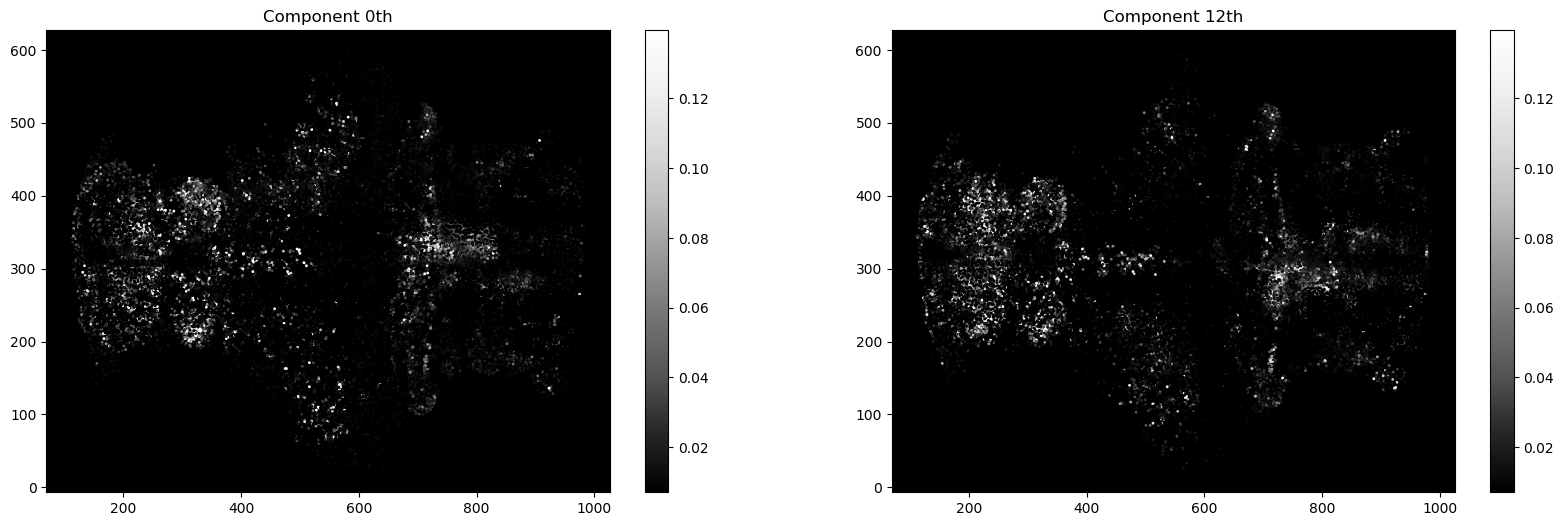

In [499]:
#Each Component's neural factor plot
scaler= MinMaxScaler().fit(df_1.values[:, 1].reshape(-1, 2))
norm_sub_1 = scaler.transform(df_1.values[:, 1].reshape(-1, 2)).reshape(-1, 1)

scaler= MinMaxScaler().fit(df_1.values[:, 13].reshape(-1, 2))
norm_sub_2 = scaler.transform(df_1.values[:, 13].reshape(-1, 2)).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)

med_sub1 = np.median(norm_sub_1)
std_sub1 = np.std(norm_sub_1)

med_sub2 = np.median(norm_sub_2)
std_sub2 = np.std(norm_sub_2)

ax0 = ax[0].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_sub_1[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_sub1, vmax=med_sub1+std_sub1*6)
ax0 = ax[0].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_sub_1[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_sub1, vmax=med_sub1+std_sub1*6)
ax[0].set_title('Component 0th')
plt.colorbar(ax0, ax=ax[0])


ax1 = ax[1].scatter(Cell[np.nonzero(Cell[:, 1]<303)[0], 0], Cell[np.nonzero(Cell[:, 1]<303)[0], 1], s=1, c=norm_sub_2[np.nonzero(Cell[:, 1]<303)[0], 0], cmap='Greys_r', vmin=med_sub2, vmax=med_sub2+std_sub2*6)
ax1 = ax[1].scatter(Cell[np.nonzero(Cell[:, 1]>303)[0], 0], Cell[np.nonzero(Cell[:, 1]>303)[0], 1], s=1, c=norm_sub_2[np.nonzero(Cell[:, 1]>303)[0], 0], cmap='Greys_r', vmin=med_sub2, vmax=med_sub2+std_sub2*6)
ax[1].set_title('Component 12th')
plt.colorbar(ax0, ax=ax[1])

#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
#ax.spines['right'].set_color('white')
#ax.spines['left'].set_color('white')
#ax.yaxis.label.set_color('white')
#ax.xaxis.label.set_color('white')
#ax.patch.set_facecolor('black')
plt.savefig('Each_comp_visual.png', dpi=600)

plt.show()

In [8]:
#Cross validation
mask_10 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.1
mask_90 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.9
mask_80 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.8


array([[[ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True]],

       [[ True,  True, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [False,  True, False, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True, False],
        [ True,  True,  True, ...,  True,  Tr

In [271]:
mask_10 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.1
mask_90 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.9
mask_80 = np.random.rand(np.shape(real_stim)[0], np.shape(real_stim)[1], np.shape(real_stim)[2]) >.8

R = range(1, 20)
# Fit nonnegative tensor decomposition.
#U_90, U_10 = {}, {}
U_80 = {}
for r in R:
    print(r)
    #U_90[r] = tt.ncp_hals(real_stim, rank=r, mask=mask_90, verbose=True)
    #U_10[r] = tt.ncp_hals(real_stim, rank=r, mask=mask_10, verbose=True)
    U_80[r] = tt.ncp_hals(real_stim, rank=r, mask=mask_80, verbose=True)

1
NCP_HALS: iteration 1, objective 0.6237544310511854, improvement inf.
NCP_HALS: iteration 2, objective 0.5978910400558207, improvement 0.02586339099536472.
NCP_HALS: iteration 3, objective 0.5791616868695524, improvement 0.018729353186268338.
NCP_HALS: iteration 4, objective 0.5669087439228296, improvement 0.012252942946722745.
NCP_HALS: iteration 5, objective 0.559229632857198, improvement 0.007679111065631683.
NCP_HALS: iteration 6, objective 0.5544699517390284, improvement 0.004759681118169601.
NCP_HALS: iteration 7, objective 0.5515107228612985, improvement 0.0029592288777298137.
NCP_HALS: iteration 8, objective 0.549656638121442, improvement 0.0018540847398564875.
NCP_HALS: iteration 9, objective 0.5484855798997845, improvement 0.0011710582216575283.
NCP_HALS: iteration 10, objective 0.5477408334418601, improvement 0.0007447464579244389.
NCP_HALS: iteration 11, objective 0.5472646346742843, improvement 0.00047619876757576396.
NCP_HALS: iteration 12, objective 0.5469588784693973,

NCP_HALS: iteration 31, objective 0.5194643301848818, improvement 5.83051236475729e-05.
NCP_HALS: iteration 32, objective 0.5194101135667277, improvement 5.42166181540793e-05.
NCP_HALS: iteration 33, objective 0.5193594926041939, improvement 5.062096253383164e-05.
NCP_HALS: iteration 34, objective 0.5193120559318656, improvement 4.743667232831594e-05.
NCP_HALS: iteration 35, objective 0.5192674598322377, improvement 4.459609962792488e-05.
NCP_HALS: iteration 36, objective 0.5192254142439955, improvement 4.204558824216775e-05.
NCP_HALS: iteration 37, objective 0.5191857680387277, improvement 3.964620526775153e-05.
NCP_HALS: iteration 38, objective 0.5191484201482922, improvement 3.7347890435524e-05.
NCP_HALS: iteration 39, objective 0.519113104951023, improvement 3.53151972691812e-05.
NCP_HALS: iteration 40, objective 0.5190795796241243, improvement 3.352532689870902e-05.
NCP_HALS: iteration 41, objective 0.5190478679564635, improvement 3.1711667660805354e-05.
NCP_HALS: iteration 42, ob

NCP_HALS: iteration 51, objective 0.5136409965683398, improvement 2.3999333590762895e-05.
NCP_HALS: iteration 52, objective 0.5136174229511523, improvement 2.3573617187522267e-05.
NCP_HALS: iteration 53, objective 0.5135942720579832, improvement 2.3150893169066045e-05.
NCP_HALS: iteration 54, objective 0.5135715348366229, improvement 2.2737221360369375e-05.
NCP_HALS: iteration 55, objective 0.5135492063297245, improvement 2.2328506898428024e-05.
NCP_HALS: iteration 56, objective 0.5135272815528332, improvement 2.1924776891224518e-05.
NCP_HALS: iteration 57, objective 0.5135057510668652, improvement 2.1530485967979907e-05.
NCP_HALS: iteration 58, objective 0.5134846106642159, improvement 2.1140402649333367e-05.
NCP_HALS: iteration 59, objective 0.5134638968869092, improvement 2.0713777306724523e-05.
NCP_HALS: iteration 60, objective 0.5134436007062312, improvement 2.0296180678003317e-05.
NCP_HALS: iteration 61, objective 0.5134236882648234, improvement 1.99124414077545e-05.
NCP_HALS: it

NCP_HALS: iteration 49, objective 0.5078175736740008, improvement 6.166712135136088e-05.
NCP_HALS: iteration 50, objective 0.5077585824868127, improvement 5.8991187188106586e-05.
NCP_HALS: iteration 51, objective 0.5077020472942302, improvement 5.65351925825297e-05.
NCP_HALS: iteration 52, objective 0.5076480983785657, improvement 5.394891566445903e-05.
NCP_HALS: iteration 53, objective 0.5075965419736288, improvement 5.155640493692548e-05.
NCP_HALS: iteration 54, objective 0.5075473371135756, improvement 4.920486005322022e-05.
NCP_HALS: iteration 55, objective 0.507500431101931, improvement 4.690601164458741e-05.
NCP_HALS: iteration 56, objective 0.5074557216284716, improvement 4.470947345935894e-05.
NCP_HALS: iteration 57, objective 0.5074130739693313, improvement 4.264765914030466e-05.
NCP_HALS: iteration 58, objective 0.5073724857553796, improvement 4.058821395169776e-05.
NCP_HALS: iteration 59, objective 0.5073340157185546, improvement 3.8470036825000165e-05.
NCP_HALS: iteration 6

NCP_HALS: iteration 57, objective 0.5044528827608512, improvement 2.4113767993938495e-05.
NCP_HALS: iteration 58, objective 0.5044295085450562, improvement 2.337421579501342e-05.
NCP_HALS: iteration 59, objective 0.5044067991613242, improvement 2.2709383731944754e-05.
NCP_HALS: iteration 60, objective 0.5043847039585366, improvement 2.2095202787619783e-05.
NCP_HALS: iteration 61, objective 0.5043631800612178, improvement 2.1523897318798113e-05.
NCP_HALS: iteration 62, objective 0.5043422440450256, improvement 2.093601619224117e-05.
NCP_HALS: iteration 63, objective 0.5043218324365296, improvement 2.0411608495973788e-05.
NCP_HALS: iteration 64, objective 0.504301871934559, improvement 1.9960501970617273e-05.
NCP_HALS: iteration 65, objective 0.5042823470973055, improvement 1.9524837253537264e-05.
NCP_HALS: iteration 66, objective 0.5042632284598311, improvement 1.9118637474391242e-05.
NCP_HALS: iteration 67, objective 0.5042444669544699, improvement 1.87615053611756e-05.
NCP_HALS: itera

NCP_HALS: iteration 37, objective 0.5010221897240662, improvement 9.473153143191304e-05.
NCP_HALS: iteration 38, objective 0.5009330679353124, improvement 8.912178875375432e-05.
NCP_HALS: iteration 39, objective 0.5008492010435383, improvement 8.386689177419804e-05.
NCP_HALS: iteration 40, objective 0.5007703918853672, improvement 7.880915817104484e-05.
NCP_HALS: iteration 41, objective 0.5006960381766039, improvement 7.435370876329728e-05.
NCP_HALS: iteration 42, objective 0.5006258358843778, improvement 7.020229222609586e-05.
NCP_HALS: iteration 43, objective 0.5005593496925612, improvement 6.648619181659488e-05.
NCP_HALS: iteration 44, objective 0.5004962395459193, improvement 6.311014664195369e-05.
NCP_HALS: iteration 45, objective 0.500436328097787, improvement 5.99114481322216e-05.
NCP_HALS: iteration 46, objective 0.5003792774011945, improvement 5.705069659256434e-05.
NCP_HALS: iteration 47, objective 0.5003249232178708, improvement 5.435418332366826e-05.
NCP_HALS: iteration 48,

NCP_HALS: iteration 4, objective 0.5365749792402117, improvement 0.011104833267267078.
NCP_HALS: iteration 5, objective 0.527675262341406, improvement 0.008899716898805643.
NCP_HALS: iteration 6, objective 0.5208669988457162, improvement 0.006808263495689859.
NCP_HALS: iteration 7, objective 0.5158928539029813, improvement 0.004974144942734848.
NCP_HALS: iteration 8, objective 0.5122900020981955, improvement 0.0036028518047858116.
NCP_HALS: iteration 9, objective 0.5096621543580938, improvement 0.0026278477401017186.
NCP_HALS: iteration 10, objective 0.5077031139105521, improvement 0.0019590404475416934.
NCP_HALS: iteration 11, objective 0.5062077728378152, improvement 0.0014953410727369665.
NCP_HALS: iteration 12, objective 0.5050469482666065, improvement 0.0011608245712086962.
NCP_HALS: iteration 13, objective 0.5041239879305288, improvement 0.0009229603360776384.
NCP_HALS: iteration 14, objective 0.5033782801876893, improvement 0.000745707742839552.
NCP_HALS: iteration 15, objective

NCP_HALS: iteration 96, objective 0.49564694329300824, improvement 1.5466297093480463e-05.
NCP_HALS: iteration 97, objective 0.4956316338018258, improvement 1.5309491182446955e-05.
NCP_HALS: iteration 98, objective 0.4956164719606799, improvement 1.5161841145860944e-05.
NCP_HALS: iteration 99, objective 0.495601427791869, improvement 1.5044168810929293e-05.
NCP_HALS: iteration 100, objective 0.4955864953015771, improvement 1.4932490291885703e-05.
NCP_HALS: iteration 101, objective 0.49557165609873194, improvement 1.4839202845173816e-05.
NCP_HALS: iteration 102, objective 0.4955569059553759, improvement 1.4750143356057066e-05.
NCP_HALS: iteration 103, objective 0.4955423037907481, improvement 1.4602164627786074e-05.
NCP_HALS: iteration 104, objective 0.4955277716019721, improvement 1.4532188776006372e-05.
NCP_HALS: iteration 105, objective 0.49551328678981443, improvement 1.4484812157655735e-05.
NCP_HALS: iteration 106, objective 0.4954988621346289, improvement 1.4424655185529822e-05.
N

NCP_HALS: iteration 14, objective 0.5022405662045565, improvement 0.0010618744638745126.
NCP_HALS: iteration 15, objective 0.5013299279908001, improvement 0.0009106382137563651.
NCP_HALS: iteration 16, objective 0.5005436908804058, improvement 0.0007862371103942722.
NCP_HALS: iteration 17, objective 0.49985616924970433, improvement 0.0006875216307015153.
NCP_HALS: iteration 18, objective 0.49925287900702026, improvement 0.0006032902426840736.
NCP_HALS: iteration 19, objective 0.49871794458962193, improvement 0.000534934417398325.
NCP_HALS: iteration 20, objective 0.4982387917630174, improvement 0.0004791528266045453.
NCP_HALS: iteration 21, objective 0.49780703008763755, improvement 0.0004317616753798381.
NCP_HALS: iteration 22, objective 0.497415157592424, improvement 0.00039187249521355216.
NCP_HALS: iteration 23, objective 0.49705742931850055, improvement 0.0003577282739234411.
NCP_HALS: iteration 24, objective 0.496731439356432, improvement 0.00032598996206856246.
NCP_HALS: iterati

NCP_HALS: iteration 12, objective 0.5006561699588267, improvement 0.0014936229933829592.
NCP_HALS: iteration 13, objective 0.49943826053119666, improvement 0.001217909427630004.
NCP_HALS: iteration 14, objective 0.49844122060175233, improvement 0.0009970399294443322.
NCP_HALS: iteration 15, objective 0.49761940629709517, improvement 0.0008218143046571647.
NCP_HALS: iteration 16, objective 0.4969341346070658, improvement 0.0006852716900293543.
NCP_HALS: iteration 17, objective 0.49635675748979236, improvement 0.0005773771172734588.
NCP_HALS: iteration 18, objective 0.4958661080766315, improvement 0.0004906494131608485.
NCP_HALS: iteration 19, objective 0.4954419632132686, improvement 0.00042414486336289636.
NCP_HALS: iteration 20, objective 0.49507269740317383, improvement 0.00036926581009477655.
NCP_HALS: iteration 21, objective 0.49474750203502893, improvement 0.0003251953681449038.
NCP_HALS: iteration 22, objective 0.4944598014009771, improvement 0.0002877006340518129.
NCP_HALS: iter

NCP_HALS: iteration 104, objective 0.4893080134204266, improvement 2.0640532575444404e-05.
NCP_HALS: iteration 105, objective 0.48928802814639744, improvement 1.998527402918837e-05.
NCP_HALS: iteration 106, objective 0.48926866907906513, improvement 1.935906733230297e-05.
NCP_HALS: iteration 107, objective 0.4892499140740343, improvement 1.875500503084604e-05.
NCP_HALS: iteration 108, objective 0.4892317346012238, improvement 1.8179472810464503e-05.
NCP_HALS: iteration 109, objective 0.4892141088337477, improvement 1.7625767476103782e-05.
NCP_HALS: iteration 110, objective 0.48919702409200555, improvement 1.708474174216823e-05.
NCP_HALS: iteration 111, objective 0.4891804672213732, improvement 1.65568706323449e-05.
NCP_HALS: iteration 112, objective 0.48916441100236036, improvement 1.6056219012849926e-05.
NCP_HALS: iteration 113, objective 0.48914883633596307, improvement 1.5574666397288883e-05.
NCP_HALS: iteration 114, objective 0.48913373477950517, improvement 1.5101556457897125e-05.

NCP_HALS: iteration 67, objective 0.4877264768942777, improvement 3.1396627309110414e-05.
NCP_HALS: iteration 68, objective 0.4876959549211644, improvement 3.0521973113317724e-05.
NCP_HALS: iteration 69, objective 0.487666257672441, improvement 2.969724872342594e-05.
NCP_HALS: iteration 70, objective 0.48763730433051056, improvement 2.8953341930426646e-05.
NCP_HALS: iteration 71, objective 0.4876091207415848, improvement 2.8183588925756453e-05.
NCP_HALS: iteration 72, objective 0.4875816756080979, improvement 2.744513348690303e-05.
NCP_HALS: iteration 73, objective 0.48755488131351005, improvement 2.6794294587850764e-05.
NCP_HALS: iteration 74, objective 0.4875287250508744, improvement 2.6156262635634864e-05.
NCP_HALS: iteration 75, objective 0.4875031726405336, improvement 2.5552410340801135e-05.
NCP_HALS: iteration 76, objective 0.487478178424953, improvement 2.4994215580609325e-05.
NCP_HALS: iteration 77, objective 0.48745372112722235, improvement 2.4457297730651195e-05.
NCP_HALS: i

NCP_HALS: iteration 37, objective 0.48613489604810706, improvement 0.00017525947900187688.
NCP_HALS: iteration 38, objective 0.4859683437799694, improvement 0.00016655226813766522.
NCP_HALS: iteration 39, objective 0.48580963952309314, improvement 0.000158704256876252.
NCP_HALS: iteration 40, objective 0.4856578707661613, improvement 0.0001517687569318471.
NCP_HALS: iteration 41, objective 0.4855127879083043, improvement 0.00014508285785697073.
NCP_HALS: iteration 42, objective 0.48537394016247226, improvement 0.00013884774583206028.
NCP_HALS: iteration 43, objective 0.4852412772811235, improvement 0.00013266288134877735.
NCP_HALS: iteration 44, objective 0.48511453635186413, improvement 0.0001267409292593502.
NCP_HALS: iteration 45, objective 0.4849931575675452, improvement 0.00012137878431894844.
NCP_HALS: iteration 46, objective 0.48487706210317816, improvement 0.00011609546436702756.
NCP_HALS: iteration 47, objective 0.4847660196848801, improvement 0.00011104241829806849.
NCP_HALS:

NCP_HALS: iteration 28, objective 0.4859835530151875, improvement 0.0003005981645597955.
NCP_HALS: iteration 29, objective 0.48570917355326226, improvement 0.00027437946192521157.
NCP_HALS: iteration 30, objective 0.48545759778896846, improvement 0.0002515757642937988.
NCP_HALS: iteration 31, objective 0.48522561308939266, improvement 0.0002319846995758046.
NCP_HALS: iteration 32, objective 0.48501067649766577, improvement 0.00021493659172688862.
NCP_HALS: iteration 33, objective 0.48481097578643756, improvement 0.0001997007112282123.
NCP_HALS: iteration 34, objective 0.48462514567196385, improvement 0.00018583011447370623.
NCP_HALS: iteration 35, objective 0.4844521561886866, improvement 0.00017298948327726382.
NCP_HALS: iteration 36, objective 0.4842903731576763, improvement 0.00016178303101027636.
NCP_HALS: iteration 37, objective 0.48413905643735067, improvement 0.00015131672032564492.
NCP_HALS: iteration 38, objective 0.4839972015062726, improvement 0.0001418549310780448.
NCP_HALS

NCP_HALS: iteration 12, objective 0.49140724301564953, improvement 0.001396537117857477.
NCP_HALS: iteration 13, objective 0.4902561141037848, improvement 0.0011511289118647516.
NCP_HALS: iteration 14, objective 0.4892912554136273, improvement 0.0009648586901574996.
NCP_HALS: iteration 15, objective 0.4884743772025759, improvement 0.0008168782110513639.
NCP_HALS: iteration 16, objective 0.48777431338802646, improvement 0.0007000638145494564.
NCP_HALS: iteration 17, objective 0.4871674622328995, improvement 0.0006068511551269862.
NCP_HALS: iteration 18, objective 0.48663698256746435, improvement 0.000530479665435124.
NCP_HALS: iteration 19, objective 0.4861680198805641, improvement 0.0004689626869002761.
NCP_HALS: iteration 20, objective 0.4857500736482695, improvement 0.00041794623229457484.
NCP_HALS: iteration 21, objective 0.48537405460314975, improvement 0.0003760190451197465.
NCP_HALS: iteration 22, objective 0.4850333978803937, improvement 0.00034065672275607195.
NCP_HALS: iterati

NCP_HALS: iteration 104, objective 0.4782783512595424, improvement 1.6778433008957094e-05.
NCP_HALS: iteration 105, objective 0.47826203713707643, improvement 1.6314122465943548e-05.
NCP_HALS: iteration 106, objective 0.4782461899984859, improvement 1.584713859054121e-05.
NCP_HALS: iteration 107, objective 0.4782308412022888, improvement 1.534879619707885e-05.
NCP_HALS: iteration 108, objective 0.47821593053707556, improvement 1.4910665213252461e-05.
NCP_HALS: iteration 109, objective 0.47820154588407415, improvement 1.438465300140912e-05.
NCP_HALS: iteration 110, objective 0.47818761211578753, improvement 1.3933768286622517e-05.
NCP_HALS: iteration 111, objective 0.4781740949238183, improvement 1.351719196923673e-05.
NCP_HALS: iteration 112, objective 0.4781609642684311, improvement 1.3130655387216805e-05.
NCP_HALS: iteration 113, objective 0.4781482041189685, improvement 1.2760149462553994e-05.
NCP_HALS: iteration 114, objective 0.47813582980315417, improvement 1.237431581435633e-05.

NCP_HALS: iteration 74, objective 0.4772049608928021, improvement 3.87589521894105e-05.
NCP_HALS: iteration 75, objective 0.4771671379863405, improvement 3.782290646164865e-05.
NCP_HALS: iteration 76, objective 0.4771302958810521, improvement 3.684210528837051e-05.
NCP_HALS: iteration 77, objective 0.47709450106162876, improvement 3.5794819423340396e-05.
NCP_HALS: iteration 78, objective 0.4770595452509219, improvement 3.4955810706838175e-05.
NCP_HALS: iteration 79, objective 0.47702540977763935, improvement 3.4135473282570494e-05.
NCP_HALS: iteration 80, objective 0.4769921176244715, improvement 3.329215316782985e-05.
NCP_HALS: iteration 81, objective 0.476959490903666, improvement 3.262672080550644e-05.
NCP_HALS: iteration 82, objective 0.47692748044566113, improvement 3.2010458004883e-05.
NCP_HALS: iteration 83, objective 0.4768960992033629, improvement 3.1381242298234024e-05.
NCP_HALS: iteration 84, objective 0.4768652374292121, improvement 3.0861774150792165e-05.
NCP_HALS: iterati

NCP_HALS: iteration 17, objective 0.48424906699202536, improvement 0.0007346158593179442.
NCP_HALS: iteration 18, objective 0.4836052117771789, improvement 0.0006438552148464449.
NCP_HALS: iteration 19, objective 0.48303230150047904, improvement 0.0005729102766998673.
NCP_HALS: iteration 20, objective 0.48252000600743394, improvement 0.0005122954930451007.
NCP_HALS: iteration 21, objective 0.48205783290629695, improvement 0.00046217310113699783.
NCP_HALS: iteration 22, objective 0.4816373166194702, improvement 0.00042051628682676645.
NCP_HALS: iteration 23, objective 0.4812523830938273, improvement 0.0003849335256428943.
NCP_HALS: iteration 24, objective 0.4808975328886871, improvement 0.00035485020514020027.
NCP_HALS: iteration 25, objective 0.48056990493648455, improvement 0.00032762795220253604.
NCP_HALS: iteration 26, objective 0.4802674569955203, improvement 0.00030244794096423444.
NCP_HALS: iteration 27, objective 0.47998575094644613, improvement 0.00028170604907418184.
NCP_HALS:

NCP_HALS: iteration 109, objective 0.47377928932164, improvement 2.3793150540296626e-05.
NCP_HALS: iteration 110, objective 0.47375597091233274, improvement 2.3318409307249155e-05.
NCP_HALS: iteration 111, objective 0.47373311618578745, improvement 2.2854726545284976e-05.
NCP_HALS: iteration 112, objective 0.47371075968669946, improvement 2.2356499087994308e-05.
NCP_HALS: iteration 113, objective 0.47368888490105204, improvement 2.1874785647413297e-05.
NCP_HALS: iteration 114, objective 0.4736674552921722, improvement 2.142960887985268e-05.
NCP_HALS: iteration 115, objective 0.473646489531584, improvement 2.0965760588187443e-05.
NCP_HALS: iteration 116, objective 0.473625973817965, improvement 2.0515713618995957e-05.
NCP_HALS: iteration 117, objective 0.4736059776022853, improvement 1.9996215679718432e-05.
NCP_HALS: iteration 118, objective 0.47358653160529796, improvement 1.9445996987332848e-05.
NCP_HALS: iteration 119, objective 0.47356759142509314, improvement 1.8940180204818358e-05

NCP_HALS: iteration 55, objective 0.4753132689755151, improvement 0.00011628488109882706.
NCP_HALS: iteration 56, objective 0.47520060889223853, improvement 0.00011266008327659449.
NCP_HALS: iteration 57, objective 0.4750915890711867, improvement 0.00010901982105182562.
NCP_HALS: iteration 58, objective 0.4749858820367908, improvement 0.00010570703439588547.
NCP_HALS: iteration 59, objective 0.4748836044631442, improvement 0.00010227757364661416.
NCP_HALS: iteration 60, objective 0.4747844743650991, improvement 9.91300980451304e-05.
NCP_HALS: iteration 61, objective 0.4746884650666929, improvement 9.600929840619665e-05.
NCP_HALS: iteration 62, objective 0.47459558181109723, improvement 9.288325559564381e-05.
NCP_HALS: iteration 63, objective 0.47450557405028826, improvement 9.000776080897444e-05.
NCP_HALS: iteration 64, objective 0.4744183672585111, improvement 8.720679177715018e-05.
NCP_HALS: iteration 65, objective 0.474333944923655, improvement 8.442233485611572e-05.
NCP_HALS: itera

NCP_HALS: iteration 15, objective 0.4839026761973547, improvement 0.0009964396441770051.
NCP_HALS: iteration 16, objective 0.48302750443238623, improvement 0.0008751717649684854.
NCP_HALS: iteration 17, objective 0.4822507081528572, improvement 0.0007767962795290351.
NCP_HALS: iteration 18, objective 0.4815579416259555, improvement 0.0006927665269017003.
NCP_HALS: iteration 19, objective 0.4809362460396663, improvement 0.0006216955862892171.
NCP_HALS: iteration 20, objective 0.48037430594817226, improvement 0.0005619400914940176.
NCP_HALS: iteration 21, objective 0.4798635781494945, improvement 0.0005107277986777792.
NCP_HALS: iteration 22, objective 0.47939643429684936, improvement 0.00046714385264512437.
NCP_HALS: iteration 23, objective 0.47896763608667436, improvement 0.00042879821017499653.
NCP_HALS: iteration 24, objective 0.4785714014215294, improvement 0.00039623466514498995.
NCP_HALS: iteration 25, objective 0.4782053173299194, improvement 0.0003660840916099861.
NCP_HALS: iter

NCP_HALS: iteration 107, objective 0.46962841097265046, improvement 4.205872340817818e-05.
NCP_HALS: iteration 108, objective 0.4695863499125144, improvement 4.2061060136044937e-05.
NCP_HALS: iteration 109, objective 0.4695442903483661, improvement 4.205956414832235e-05.
NCP_HALS: iteration 110, objective 0.46950226121417105, improvement 4.202913419504295e-05.
NCP_HALS: iteration 111, objective 0.46946026852792927, improvement 4.199268624177632e-05.
NCP_HALS: iteration 112, objective 0.46941834200168664, improvement 4.192652624263049e-05.
NCP_HALS: iteration 113, objective 0.4693766984211176, improvement 4.16435805690174e-05.
NCP_HALS: iteration 114, objective 0.46933523232800695, improvement 4.146609311067584e-05.
NCP_HALS: iteration 115, objective 0.46929399598177635, improvement 4.1236346230599796e-05.
NCP_HALS: iteration 116, objective 0.46925308443540525, improvement 4.0911546371091845e-05.
NCP_HALS: iteration 117, objective 0.46921251782754214, improvement 4.0566607863112836e-05.

NCP_HALS: iteration 30, objective 0.4742413508903916, improvement 0.0002470743332726455.
NCP_HALS: iteration 31, objective 0.47401031388838866, improvement 0.00023103700200294286.
NCP_HALS: iteration 32, objective 0.4737935119113988, improvement 0.00021680197698986658.
NCP_HALS: iteration 33, objective 0.47358912060133856, improvement 0.0002043913100602257.
NCP_HALS: iteration 34, objective 0.47339749734773356, improvement 0.000191623253605.
NCP_HALS: iteration 35, objective 0.47321769998241603, improvement 0.00017979736531753554.
NCP_HALS: iteration 36, objective 0.47304771846128296, improvement 0.00016998152113306686.
NCP_HALS: iteration 37, objective 0.4728878650120753, improvement 0.00015985344920765865.
NCP_HALS: iteration 38, objective 0.472737516647452, improvement 0.00015034836462329837.
NCP_HALS: iteration 39, objective 0.4725951512583894, improvement 0.0001423653890625931.
NCP_HALS: iteration 40, objective 0.4724597346736434, improvement 0.0001354165847460287.
NCP_HALS: itera

NCP_HALS: iteration 122, objective 0.4670193869366057, improvement 2.5782023746312444e-05.
NCP_HALS: iteration 123, objective 0.4669944454317027, improvement 2.4941504903008838e-05.
NCP_HALS: iteration 124, objective 0.46697029485963837, improvement 2.4150572064340903e-05.
NCP_HALS: iteration 125, objective 0.4669469508068488, improvement 2.3344052789586733e-05.
NCP_HALS: iteration 126, objective 0.4669243386820483, improvement 2.2612124800480693e-05.
NCP_HALS: iteration 127, objective 0.46690243683900384, improvement 2.1901843044458413e-05.
NCP_HALS: iteration 128, objective 0.4668812671132963, improvement 2.1169725707537168e-05.
NCP_HALS: iteration 129, objective 0.46686080601071916, improvement 2.0461102577140622e-05.
NCP_HALS: iteration 130, objective 0.4668409738722531, improvement 1.983213846606935e-05.
NCP_HALS: iteration 131, objective 0.4668217341376752, improvement 1.9239734577902734e-05.
NCP_HALS: iteration 132, objective 0.466803126533741, improvement 1.8607603934184258e-05

In [272]:
train_err_list=[]
test_err_list=[]
for i in range(1, 20):
    print(i)
    Xhat_90_test = U_80[i].factors.full()
    train_error = np.linalg.norm(Xhat_90_test[mask_80] - real_stim[mask_80]) / np.linalg.norm(real_stim[mask_80])
    test_error = np.linalg.norm(Xhat_90_test[~mask_80] - real_stim[~mask_80]) / np.linalg.norm(real_stim[~mask_80])
    train_err_list.append((i, train_error))
    test_err_list.append((i, test_error))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [223]:
U_90_train = np.array(train_err_list)[:, 1]
U_90_test = np.array(test_err_list)[:, 1]

In [221]:
U_10_train = np.array(train_err_list)[:, 1]
U_10_test = np.array(test_err_list)[:, 1]

In [273]:
U_80_train = np.array(train_err_list)[:, 1]
U_80_test = np.array(test_err_list)[:, 1]

In [270]:
df_U_90 = pd.DataFrame(np.transpose([U_90_train, U_90_test]), columns=['U_90_train', 'U_90_test'])
df_U_10 = pd.DataFrame(np.transpose([U_10_train, U_10_test]), columns=['U_10_train', 'U_10_test'])
df_U_90.to_csv('U_90_err_data.csv')
df_U_10.to_csv('U_10_err_data.csv')

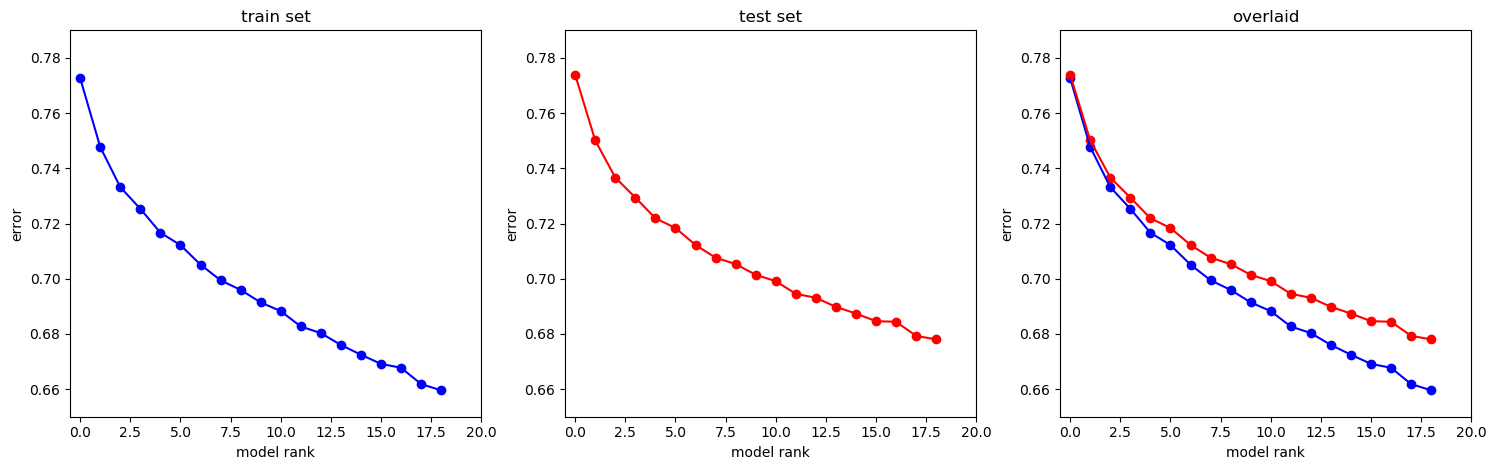

In [281]:
#U_80
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].scatter(np.arange(len(U_80_train)), U_80_train, c='blue')
ax[0].plot(np.arange(len(U_80_train)), U_80_train, c='blue')
ax[0].set_xlabel('model rank')
ax[0].set_ylabel('error')
ax[0].set_title('train set')
ax[0].set_xlim([-0.5, 20])
ax[0].set_ylim([0.65, 0.79])

ax[1].scatter(np.arange(len(U_80_test)), U_80_test, c='red')
ax[1].plot(np.arange(len(U_80_test)), U_80_test, c='red')
ax[1].set_xlabel('model rank')
ax[1].set_ylabel('error')
ax[1].set_title('test set')
ax[1].set_xlim([-0.5, 20])
ax[1].set_ylim([0.65, 0.79])

ax[2].scatter(np.arange(len(U_80_train)), U_80_train, c='blue')
ax[2].scatter(np.arange(len(U_80_test)), U_80_test, c='red')
ax[2].plot(np.arange(len(U_80_train)), U_80_train, c='blue')
ax[2].plot(np.arange(len(U_80_test)), U_80_test, c='red')
ax[2].set_xlabel('model rank')
ax[2].set_ylabel('error')
ax[2].set_title('overlaid')
ax[2].set_xlim([-0.5, 20])
ax[2].set_ylim([0.65, 0.79])

fig.set_figwidth(15)
fig.tight_layout()
plt.savefig('U_80_plot.png')

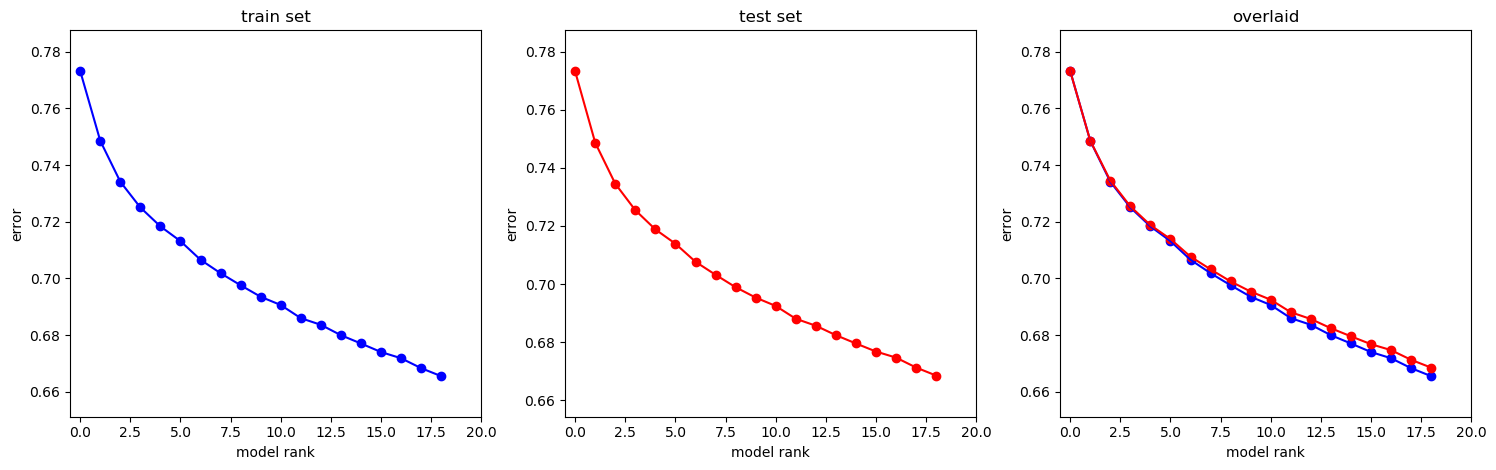

In [254]:
#U_10
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].scatter(np.arange(len(U_10_train)), U_10_train, c='blue')
ax[0].plot(np.arange(len(U_10_train)), U_10_train, c='blue')
ax[0].set_xlabel('model rank')
ax[0].set_ylabel('error')
ax[0].set_title('train set')
ax[0].set_xlim([-0.5, 20])

ax[1].scatter(np.arange(len(U_10_test)), U_10_test, c='red')
ax[1].plot(np.arange(len(U_10_test)), U_10_test, c='red')
ax[1].set_xlabel('model rank')
ax[1].set_ylabel('error')
ax[1].set_title('test set')
ax[1].set_xlim([-0.5, 20])

ax[2].scatter(np.arange(len(U_10_train)), U_10_train, c='blue')
ax[2].scatter(np.arange(len(U_10_test)), U_10_test, c='red')
ax[2].plot(np.arange(len(U_10_train)), U_10_train, c='blue')
ax[2].plot(np.arange(len(U_10_test)), U_10_test, c='red')
ax[2].set_xlabel('model rank')
ax[2].set_ylabel('error')
ax[2].set_title('overlaid')
ax[2].set_xlim([-0.5, 20])

fig.set_figwidth(15)
fig.tight_layout()
plt.savefig('U_10_plot.png')

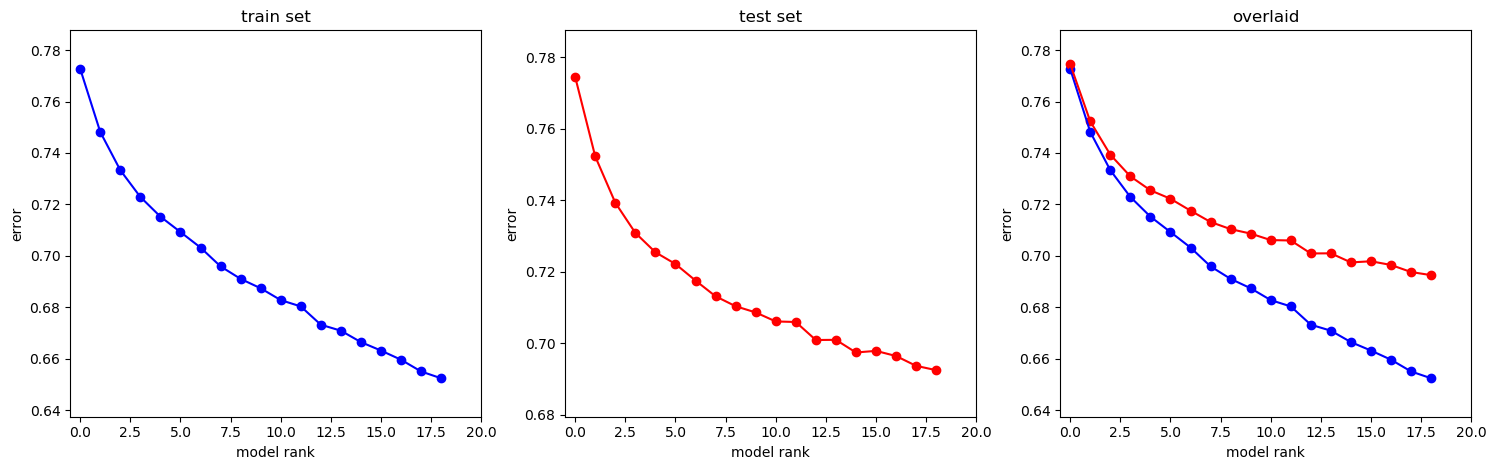

In [256]:
#U_90
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].scatter(np.arange(len(U_90_train)), U_90_train, c='blue')
ax[0].plot(np.arange(len(U_90_train)), U_90_train, c='blue')
ax[0].set_xlabel('model rank')
ax[0].set_ylabel('error')
ax[0].set_title('train set')
ax[0].set_xlim([-0.5, 20])

ax[1].scatter(np.arange(len(U_90_test)), U_90_test, c='red')
ax[1].plot(np.arange(len(U_90_test)), U_90_test, c='red')
ax[1].set_xlabel('model rank')
ax[1].set_ylabel('error')
ax[1].set_title('test set')
ax[1].set_xlim([-0.5, 20])

ax[2].scatter(np.arange(len(U_90_train)), U_90_train, c='blue')
ax[2].scatter(np.arange(len(U_90_test)), U_90_test, c='red')
ax[2].plot(np.arange(len(U_90_train)), U_90_train, c='blue')
ax[2].plot(np.arange(len(U_90_test)), U_90_test, c='red')
ax[2].set_xlabel('model rank')
ax[2].set_ylabel('error')
ax[2].set_title('overlaid')
ax[2].set_xlim([-0.5, 20])

fig.set_figwidth(15)
fig.tight_layout()
plt.savefig('U_90_plot.png')

In [546]:
df_1 = pd.DataFrame(ensembles['ncp_bcd'].factors(17)[7][0])
df_2 = pd.DataFrame(ensembles['ncp_bcd'].factors(17)[7][1])
df_3 = pd.DataFrame(ensembles['ncp_bcd'].factors(17)[7][2])

df_1.to_csv('17_7_1.csv')
df_2.to_csv('17_7_2.csv')
df_3.to_csv('17_7_3.csv')

In [71]:
cd C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6\bcd

C:\Users\Sanghun Jee\Desktop\Misha\GUI_data_examplefish\subject_6\bcd


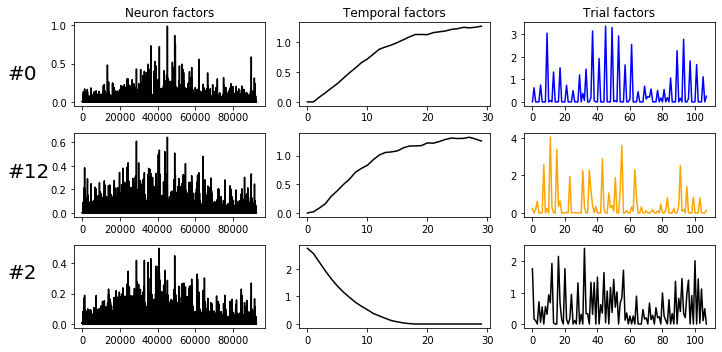

In [153]:
#Representative components

fig, ax = plt.subplots(figsize=(10, 5), nrows=3, ncols=3)

ax[0, 0].plot(df[0].iloc[:, 1], c='black')
ax[1, 0].plot(df[0].iloc[:, 13], c='black')
ax[2, 0].plot(df[0].iloc[:, 3], c='black')

ax[0, 1].plot(df[1].iloc[:, 1], c='black')
ax[1, 1].plot(df[1].iloc[:, 13], c='black')
ax[2, 1].plot(df[1].iloc[:, 3], c='black')

ax[0, 2].plot(np.arange(108), df[2].iloc[:, 1], c='blue')
ax[1, 2].plot(np.arange(108), df[2].iloc[:, 13], c='orange')
ax[2, 2].plot(np.arange(108), df[2].iloc[:, 3], c='black')

ax[0, 0].set_title('Neuron factors')
ax[0, 1].set_title('Temporal factors')
ax[0, 2].set_title('Trial factors')

ax[0, 0].text(-40000, 0.3, '#0', fontsize=20)
ax[1, 0].text(-40000, 0.3, '#12', fontsize=20)
ax[2, 0].text(-40000, 0.3, '#2', fontsize=20)

fig.tight_layout()
fig.sa('represent_TCA.png', dpi=600)

In [157]:
#Dimensionality analysis

dim_list = []
for i in range(0, np.shape(real_stim)[0]):
    eig, _ = np.linalg.eig(np.matmul(real_stim[i, :, :].T, real_stim[i, :, :]))
    dim_list.append(np.sum(eig)**2/np.sum(eig**2))
    
var_list = []
for i in range(0, np.shape(real_stim)[0]):
    var_list.append(np.var(real_stim[i, :, :]))
    

(0.0001, 5)

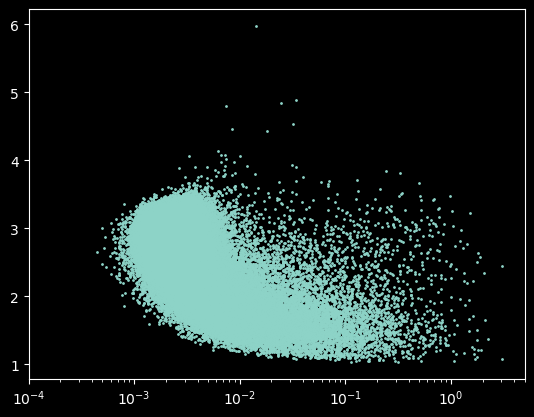

In [590]:
plt.scatter(var_list, dim_list, s=1)
plt.xscale('log')
plt.xlim([0.0003, 5])
#plt.ylim([1, 6])